## Import Libraries

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from mpl_toolkits.mplot3d import Axes3D
from dtw import dtw, accelerated_dtw
from mpl_toolkits import mplot3d
from scipy import signal
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import math
import json
import csv
import os

## Import CSVs as Dataframes

In [3]:
all_data = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\all_data.csv')
center_mass = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\center_mass.csv')
movement_mass_vector = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\movement_mass_vector.csv')
movement_vector = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\movement_vector.csv')
motion_energy = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\motion_energy_removed_frames.csv')
mov_med_motion_energy = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\moved_median_motion_energy.csv')
norm_mov_med_motion_energy = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\norm_mov_med_motion_energy.csv')
diff_norm_mov_med_motion_energy = pd.read_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\diff_norm_mov_med_motion_energy.csv')
#diff_norm_mov_med_motion_energy.head(6)
#norm_motion_energy = motion_energy.copy()
#norm_motion_energy['motion_energy_first_person'] = [i/sum(norm_motion_energy['motion_energy_first_person']) for i in norm_motion_energy['motion_energy_first_person']]
#norm_motion_energy['motion_energy_second_person'] = [i/sum(norm_motion_energy['motion_energy_second_person']) for i in norm_motion_energy['motion_energy_second_person']]


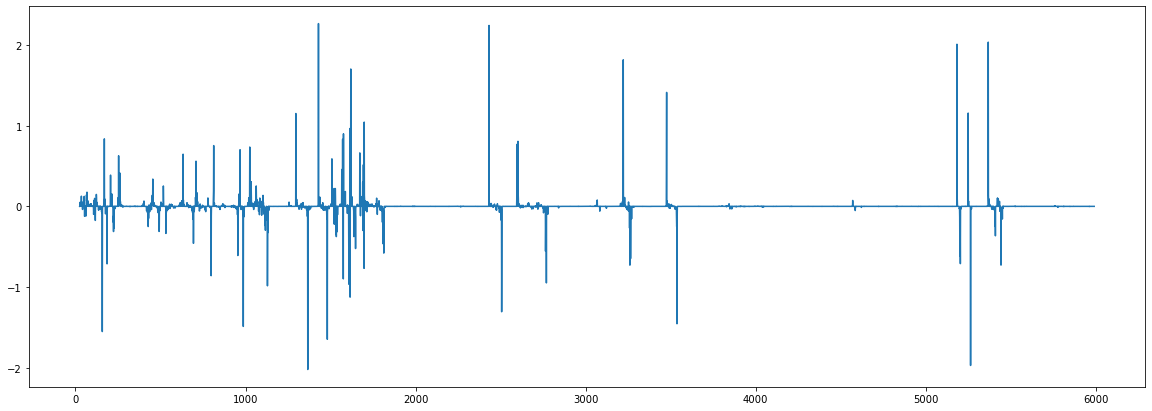

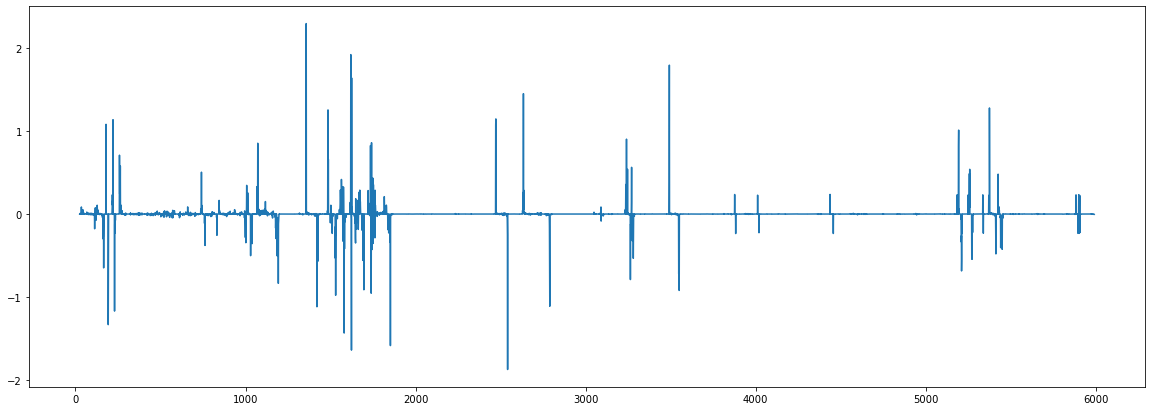

In [4]:
plt.figure(figsize=(20,7))
plt.plot(diff_norm_mov_med_motion_energy['frames'], diff_norm_mov_med_motion_energy['motion_energy_first_person'])
plt.show()

plt.figure(figsize=(20,7))
plt.plot(diff_norm_mov_med_motion_energy['frames'], diff_norm_mov_med_motion_energy['motion_energy_second_person'])
plt.show()

## Pearson correlation

Pandas computed Pearson r: 0.6622001133090306
Scipy computed Pearson r: 0.6622001133090349 and p-value: 0.0


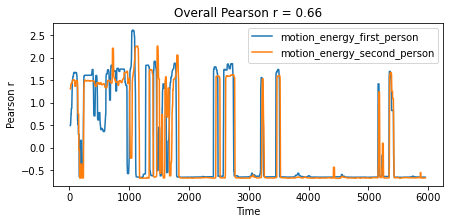

In [32]:
diff_norm_mov_med_motion_energy1 = norm_mov_med_motion_energy.copy()
diff_norm_mov_med_motion_energy1 = diff_norm_mov_med_motion_energy1.drop('frames', axis=1)

overall_pearson_r = diff_norm_mov_med_motion_energy1.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(diff_norm_mov_med_motion_energy1.dropna()['motion_energy_first_person'], diff_norm_mov_med_motion_energy1.dropna()['motion_energy_second_person'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
diff_norm_mov_med_motion_energy1.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

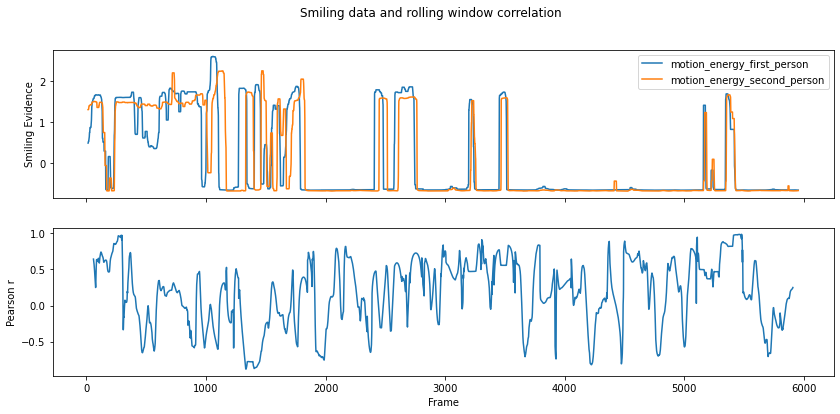

In [33]:
# Set window size to compute moving window synchrony.
r_window_size = 120
# Compute rolling window synchrony
rolling_r = diff_norm_mov_med_motion_energy1['motion_energy_first_person'].rolling(window=r_window_size, center=True).corr(diff_norm_mov_med_motion_energy1['motion_energy_second_person'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
diff_norm_mov_med_motion_energy1.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

## Time Lagged Cross Correlation — assessing signal dynamics

In [5]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation.
    Shifted data filled with NaNs

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

<ipython-input-6-29c11f890f7a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item - 290) for item in ax.get_xticks()])


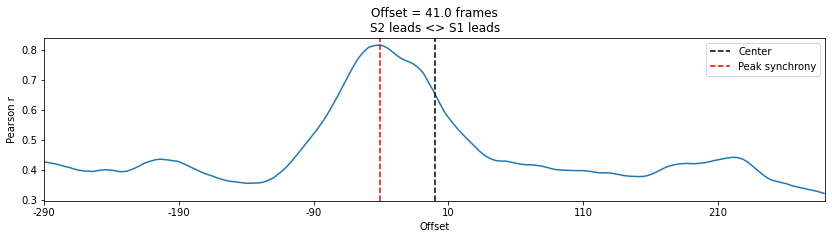

In [6]:
d1 = norm_mov_med_motion_energy['motion_energy_first_person']
d2 = norm_mov_med_motion_energy['motion_energy_second_person']
seconds = 5
fps = 58
rs = [crosscorr(d1, d2, lag) for lag in range(-int(seconds * fps - 1), int(seconds * fps+1))]
offset = np.ceil(len(rs) / 2) - np.argmax(rs)
f, ax = plt.subplots(figsize=(14, 3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs) / 2), color='k', linestyle='--', label='Center')
ax.axvline(np.argmax(rs), color='r', linestyle='--', label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS2 leads <> S1 leads', xlim=[0, 580], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item - 290) for item in ax.get_xticks()])
plt.legend()
plt.show()

## Windowed time lagged cross correlation

C:\Users\RATL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\RATL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


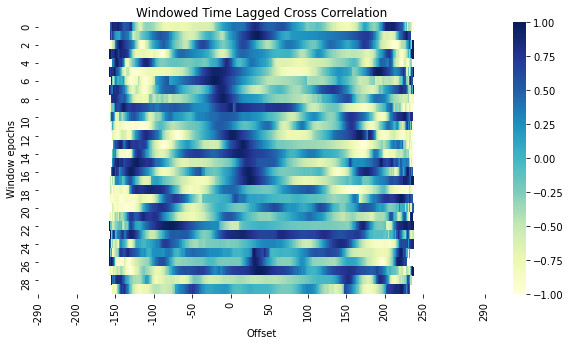

In [7]:
# Window epochs are 30. Each epoch has ~ 200 frames -> ~ 6 seconds
seconds = 5
fps = 58
no_splits = 30
samples_per_split = norm_mov_med_motion_energy.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = norm_mov_med_motion_energy['motion_energy_first_person'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = norm_mov_med_motion_energy['motion_energy_second_person'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='YlGnBu',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,580], xlabel='Offset',ylabel='Window epochs')
ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 580])
ax.set_xticklabels([-290, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 290]);

## Rolling window time lagged cross correlation

C:\Users\RATL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\RATL\anaconda3\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


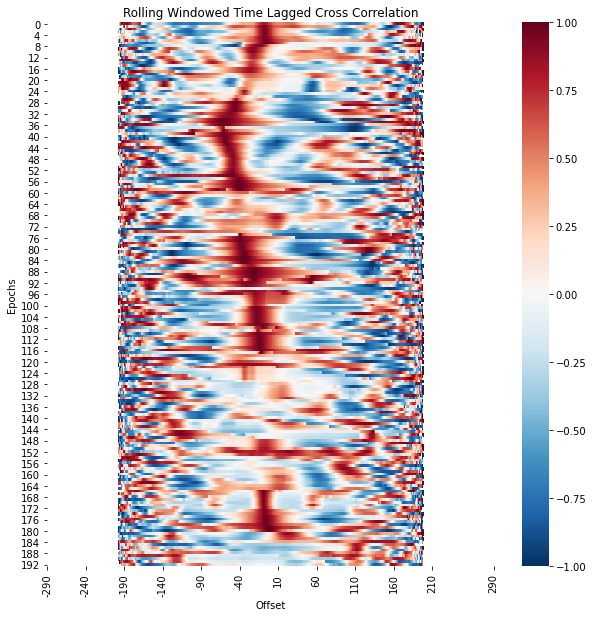

In [45]:
seconds = 5
fps = 58
window_size = 200 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < len(norm_mov_med_motion_energy):
    d1 = norm_mov_med_motion_energy['motion_energy_first_person'].iloc[t_start:t_end]
    d2 = norm_mov_med_motion_energy['motion_energy_second_person'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,580], xlabel='Offset',ylabel='Epochs')
ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 580])
ax.set_xticklabels([-290, -240, -190, -140, -90, -40, 10, 60, 110, 160, 210, 290]);

## Dynamic Time Warping — synchrony of signals varying in lengths

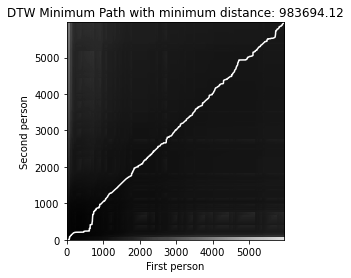

In [10]:
from dtw import dtw,accelerated_dtw

d1 = mov_med_motion_energy['motion_energy_first_person'].interpolate().values
d2 = mov_med_motion_energy['motion_energy_second_person'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('First person')
plt.ylabel('Second person')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

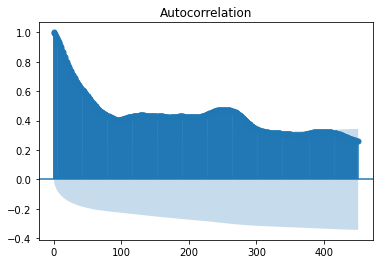

In [20]:
plot_acf(norm_mov_med_motion_energy['motion_energy_second_person'], lags=450)
plt.show()

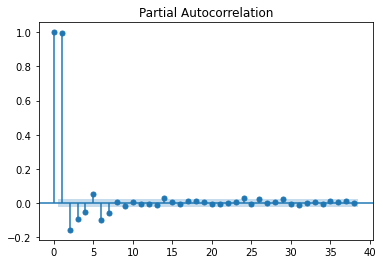

In [10]:
plot_pacf(norm_mov_med_motion_energy['motion_energy_second_person'])
plt.show()

In [29]:
diff_norm_mov_med_motion_energy2 = norm_mov_med_motion_energy['motion_energy_second_person'] - norm_mov_med_motion_energy['motion_energy_second_person'].shift(1)
diff_norm_mov_med_motion_energy1 = norm_mov_med_motion_energy['motion_energy_first_person'] - norm_mov_med_motion_energy['motion_energy_first_person'].shift(1)

C:\Users\RATL\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


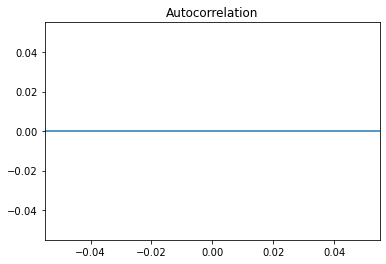

In [30]:
plot_acf(diff_norm_mov_med_motion_energy2)
plt.show()

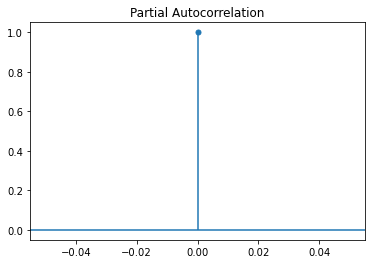

In [31]:
plot_pacf(diff_norm_mov_med_motion_energy2)
plt.show()

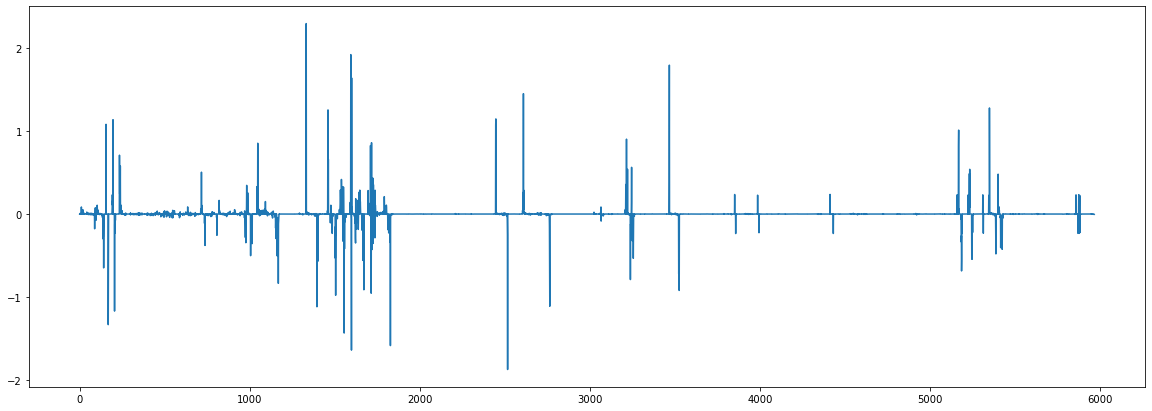

In [32]:
plt.figure(figsize=(20,7))
plt.plot(diff_norm_mov_med_motion_energy2)
plt.show()

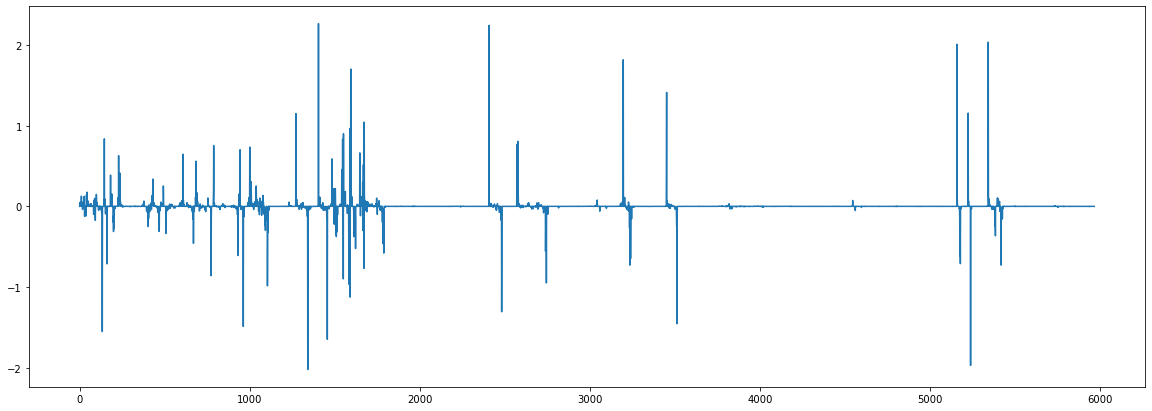

In [33]:
plt.figure(figsize=(20,7))
plt.plot(diff_norm_mov_med_motion_energy1)
plt.show()

In [38]:
differencing = {
    'motion_energy_first_person' : diff_norm_mov_med_motion_energy1,
    'motion_energy_second_person' : diff_norm_mov_med_motion_energy2,
    'frames' : norm_mov_med_motion_energy['frames']
}
motion_energy = pd.DataFrame(differencing)
motion_energy.to_csv(r'C:\Users\RATL\Desktop\openpose\output\mho_database\diff_norm_mov_med_motion_energy.csv', index=False)